In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
sys.path.append("../data/biasbios")
sys.path.append("../data/embeddings/biasbios")
import classifier
import debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer
from pytorch_transformers import BertTokenizer, BertModel, BertForMaskedLM

import scipy
from scipy import linalg
from scipy import sparse
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, SGDRegressor, Perceptron, LogisticRegression

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

import warnings
warnings.filterwarnings("ignore")

import pickle
from collections import defaultdict, Counter
from typing import List, Dict

import torch
from torch import utils

# import pytorch_lightning as pl
# from pytorch_lightning import Trainer
import copy
import pandas as pd
from gensim.models import FastText
import time
from gensim.scripts.glove2word2vec import glove2word2vec

STOPWORDS = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

### Load data

In [2]:
def load_dataset(path):
    
    with open(path, "rb") as f:
        
        data = pickle.load(f)
    return data

def load_dictionary(path):
    
    with open(path, "r", encoding = "utf-8") as f:
        
        lines = f.readlines()
        
    k2v, v2k = {}, {}
    for line in lines:
        
        k,v = line.strip().split("\t")
        v = int(v)
        k2v[k] = v
        v2k[v] = k
    
    return k2v, v2k
    
def count_profs_and_gender(data: List[dict]):
    
    counter = defaultdict(Counter)
    for entry in data:
        gender, prof = entry["g"], entry["p"]
        counter[prof][gender] += 1
        
    return counter

### Load original data (train.pickle etc.) and pre-calculated BERT CLS states ("train_cls.npy" etc.)

In [3]:
train = load_dataset("../data/biasbios/train.pickle")
dev = load_dataset("../data/biasbios/dev.pickle")
test = load_dataset("../data/biasbios/test.pickle")
counter = count_profs_and_gender(train+dev+test)
p2i, i2p = load_dictionary("../data/biasbios/profession2index.txt")
g2i, i2g = load_dictionary("../data/biasbios/gender2index.txt")

path = "../data/bert_encode_biasbios/"
x_train = np.load(path + "train_cls.npy")
x_dev = np.load(path + "dev_cls.npy")
x_test = np.load(path + "test_cls.npy")

assert len(train) == len(x_train)
assert len(dev) == len(x_dev)
assert len(test) == len(x_test)

f,m = 0., 0.
prof2fem = dict()

for k, values in counter.items():
    f += values['f']
    m += values['m']
    prof2fem[k] = values['f']/(values['f'] + values['m'])

print(f / (f + m))
print(prof2fem)

0.44541700643683746
{'professor': 0.4533699535765501, 'psychologist': 0.627327974906881, 'pastor': 0.2583668005354752, 'comedian': 0.21605667060212513, 'nurse': 0.9126009126009126, 'yoga_teacher': 0.825, 'attorney': 0.3766122913505311, 'photographer': 0.3563658099222953, 'composer': 0.16329625884732052, 'model': 0.7858407079646018, 'surgeon': 0.12832108535895986, 'physician': 0.4158485273492286, 'software_engineer': 0.17130434782608694, 'poet': 0.5133630289532294, 'painter': 0.47116788321167885, 'dj': 0.1636828644501279, 'journalist': 0.5159589626674266, 'architect': 0.23372781065088757, 'paralegal': 0.8618677042801557, 'dentist': 0.3672911787665886, 'personal_trainer': 0.4410377358490566, 'teacher': 0.5943396226415094, 'accountant': 0.3950091296409008, 'interior_designer': 0.7874493927125507, 'dietitian': 0.934412955465587, 'filmmaker': 0.3533007334963325, 'chiropractor': 0.3069908814589666, 'rapper': 0.09438775510204081}


In [4]:
y_train = np.array([p2i[entry["p"]] for entry in train])
y_dev = np.array([p2i[entry["p"]] for entry in dev])
y_test = np.array([p2i[entry["p"]] for entry in test])

In [5]:
train[1]

{'g': 'm',
 'p': 'professor',
 'text': 'Dr. Bilal Gonen is an Assistant Professor in the Computer Science Department at the University of West Florida. He received his Ph.D. from University of Nevada, Reno. He received his M.S. from the University of Georgia. He received a B.E. in Computer Engineering in Turkey. His teaching and research interests include Network Science, Social Network Analysis, Semantic Web, Computer Networks, Machine learning, Data Mining, Bioinformatics, programming in Java, C, C++, C#, Python.',
 'start': 111,
 'hard_text': 'He received his Ph.D. from University of Nevada, Reno. He received his M.S. from the University of Georgia. He received a B.E. in Computer Engineering in Turkey. His teaching and research interests include Network Science, Social Network Analysis, Semantic Web, Computer Networks, Machine learning, Data Mining, Bioinformatics, programming in Java, C, C++, C#, Python.',
 'text_without_gender': '_ received _ Ph.D. from University of Nevada, Reno.

### Train a profession classifier

In [6]:
random.seed(0)
np.random.seed(0)

clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "saga", multi_class = 'multinomial', fit_intercept = False,
                         verbose = 5, n_jobs = 90, random_state = 1, max_iter = 7)

#params = {'}
#clf = SGDClassifier(loss= 'hinge', max_iter = 4000, fit_intercept= True, class_weight= None, n_jobs= 100)
        
        
start = time.time()
idx = np.random.rand(x_train.shape[0]) < 1.0
clf.fit(x_train[idx], y_train[idx])
print("time: {}".format(time.time() - start))
print(clf.score(x_test, y_test))
clf_original = copy.deepcopy(clf)

[Parallel(n_jobs=90)]: Using backend ThreadingBackend with 90 concurrent workers.


max_iter reached after 274 seconds
time: 274.03459429740906


[Parallel(n_jobs=90)]: Done   1 out of   1 | elapsed:  4.6min finished


0.7959226128562513


In [7]:
print(clf.score(x_train, y_train))

0.8262466280280976


## Run INLP

In [8]:
MLP = False

def get_projection_matrix(num_clfs, X_train, Y_train_gender, X_dev, Y_dev_gender, Y_train_task, Y_dev_task, dim):

    is_autoregressive = True
    min_acc = 0.
    #noise = False
    dim = 768
    n = num_clfs
    #random_subset = 1.0
    start = time.time()
    TYPE= "svm"
    
    
    if MLP:
        x_train_gender = np.matmul(x_train, clf.coefs_[0]) + clf.intercepts_[0]
        x_dev_gender = np.matmul(x_dev, clf.coefs_[0]) + clf.intercepts_[0]
    else:
        x_train_gender = x_train.copy()
        x_dev_gender = x_dev.copy()
        
    
    if TYPE == "sgd":
        gender_clf = SGDClassifier
        params = {'loss': 'hinge', 'penalty': 'l2', 'fit_intercept': False, 'class_weight': None, 'n_jobs': 32}
    else:
        gender_clf = LinearSVC
        params = {'penalty': 'l2', 'C': 0.01, 'fit_intercept': True, 'class_weight': None, "dual": False}
        
    P,rowspace_projections, Ws = debias.get_debiasing_projection(gender_clf, params, n, dim, is_autoregressive, min_acc,
                                              X_train, Y_train_gender, X_dev, Y_dev_gender,
                                       Y_train_main=Y_train_task, Y_dev_main=Y_dev_task, by_class = True)
    print("time: {}".format(time.time() - start))
    return P,rowspace_projections, Ws



num_clfs = 300
y_dev_gender = np.array([g2i[d["g"]] for d in dev])
y_train_gender = np.array([g2i[d["g"]] for d in train])
idx = np.random.rand(x_train.shape[0]) < 1.
P,rowspace_projections, Ws = get_projection_matrix(num_clfs, x_train[idx], y_train_gender[idx], x_dev, y_dev_gender, y_train, y_dev, 300)

iteration: 299, accuracy: 0.825: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [38:57<00:00,  7.79s/it]


time: 2340.4597301483154


In [9]:
# np.savez("P_BERT.npz", P = P, rowspace_projections = rowspace_projections, Ws = Ws)

In [11]:
def get_TPR(y_pred, y_true, p2i, i2p, gender):
    
    scores = defaultdict(Counter)
    prof_count_total = defaultdict(Counter)
    
    for y_hat, y, g in zip(y_pred, y_true, gender):
        
        if y == y_hat:
            
            scores[i2p[y]][g] += 1
        
        prof_count_total[i2p[y]][g] += 1
    
    tprs = defaultdict(dict)
    tprs_change = dict()
    tprs_ratio = []
    
    for profession, scores_dict in scores.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = prof_count_total[profession]["f"]
        prof_total_m = prof_count_total[profession]["m"]
        tpr_m = (good_m) / prof_total_m
        tpr_f = (good_f) / prof_total_f
        
        tprs[profession]["m"] = tpr_m
        tprs[profession]["f"] = tpr_f
        tprs_ratio.append(0)
        tprs_change[profession] = tpr_f - tpr_m
        
    return tprs, tprs_change, np.mean(np.abs(tprs_ratio))

def get_FPR2(y_pred, y_true, p2i, i2p, y_gender):
    
    fp = defaultdict(Counter)
    neg_count_total = defaultdict(Counter)
    pos_count_total = defaultdict(Counter)    


    label_set = set(y_true)
    # count false positive per gender & class
    
    for y_hat, y, g in zip(y_pred, y_true, y_gender):
        
        if y != y_hat:
            
            fp[y_hat][g] += 1 # count false positives for y_hat
    
    # count total falses per gender (conditioned on class)
    
    total_prof_g = defaultdict(Counter)
    
    # collect POSITIVES for each profession and gender
    
    for y,g in zip(y_true, y_gender):
        total_prof_g[y][g] += 1
    
    total_m = sum([total_prof_g[y]["m"] for y in label_set])
    total_f = sum([total_prof_g[y]["f"] for y in label_set])
    
    # calculate NEGATIVES for each profession and gender
    
    total_false_prof_g = defaultdict(Counter)    
    for y in label_set:
        total_false_prof_g[y]["m"] = total_m - total_prof_g[y]["m"]
        total_false_prof_g[y]["f"] = total_f - total_prof_g[y]["f"]
    
    fprs = defaultdict(dict)
    fprs_diff = dict()
    
    for profession, false_pred_dict in fp.items():

        false_male, false_female = false_pred_dict["m"],  false_pred_dict["f"]
        prof_total_false_for_male = total_false_prof_g[profession]["m"]
        prof_total_false_for_female = total_false_prof_g[profession]["f"]
        
        ftr_m = false_male/prof_total_false_for_male
        ftr_f = false_female/prof_total_false_for_female
        fprs[i2p[profession]]["m"] = ftr_m
        fprs[i2p[profession]]["f"] = ftr_f
        fprs_diff[i2p[profession]] = ftr_m - ftr_f
    
    return fprs, fprs_diff
        

    
def similarity_vs_tpr(tprs, word2vec, title, measure, prof2fem):
    
    professions = list(tprs.keys())
    #
    """ 
    sims = dict()
    gender_direction = word2vec["he"] - word2vec["she"]
    
    for p in professions:
        sim = word2vec.cosine_similarities(word2vec[p], [gender_direction])[0]
        sims[p] = sim
    """
    tpr_lst = [tprs[p] for p in professions]
    sim_lst = [prof2fem[p] for p in professions]

    #professions = [p.replace("_", " ") for p in professions if p in word2vec]
    
    plt.plot(sim_lst, tpr_lst, marker = "o", linestyle = "none")
    plt.xlabel("% women", fontsize = 13)
    plt.ylabel(r'$GAP_{female,y}^{TPR}$', fontsize = 13)
    for p in professions:
        x,y = prof2fem[p], tprs[p]
        plt.annotate(p , (x,y), size = 7, color = "red")
    plt.ylim(-0.4, 0.55)
    z = np.polyfit(sim_lst, tpr_lst, 1)
    p = np.poly1d(z)
    plt.plot(sim_lst,p(sim_lst),"r--")
    plt.savefig("{}_vs_bias_{}_bert".format(measure, title), dpi = 600)
    print("Correlation: {}; p-value: {}".format(*pearsonr(sim_lst, tpr_lst)))
    plt.show()

def rms_diff(tpr_diff):
    
    return np.sqrt(np.mean(tpr_diff**2))
    
def save_vecs_and_words(vecs, words):
    def to_string(arr):
        return "\t".join([str(x) for x in arr])
    
    with open("vecs.txt", "w") as f:
        for v in vecs:
            assert len(v) == 300
            f.write(to_string(v) + "\n")
    
    with open("labels.txt", "w") as f:
            f.write("Profession\n")
            for w in words:
                f.write(w + "\n")

### Finetune & predict profession again

In [16]:
clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 3, n_jobs = 64, random_state = 1)
#clf = SGDClassifier()
# P_rowspace = np.eye(768) - P
# mean_gender_vec = np.mean(P_rowspace.dot(x_train.T).T, axis = 0)
print(clf.fit((P.dot(x_train.T)).T, y_train))

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 36 seconds
LogisticRegression(max_iter=3, multi_class='multinomial', n_jobs=64,
                   random_state=1, solver='sag', verbose=10, warm_start=True)


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   35.7s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   35.7s finished


In [17]:
print(clf.score((P.dot(x_test.T)).T, y_test))

0.6930864711185077


In [ ]:
# clf = LogisticRegression(warm_start = True, penalty = 'l2',
#                          solver = "sag", multi_class = 'multinomial', fit_intercept = True,
#                          verbose = 10, max_iter = 3, n_jobs = 64, random_state = 1)

# clf.fit(x_train, y_train)

# print(f"Biased Train accuracy {clf.score(x_train, y_train)}")
# print(f"Biased Test accuracy {clf.score(x_test, y_test)}")
# print(f"Train accuracy {clf.score((P.dot(x_train.T)).T, y_train)}")
# print(f"Test accuracy {clf.score((P.dot(x_test.T)).T, y_test)}")

### Calcualte TPR-gap vs. %woman in profession; TPR-Gap-RMS

Correlation: 0.8911210577501446; p-value: 2.060745709586484e-10


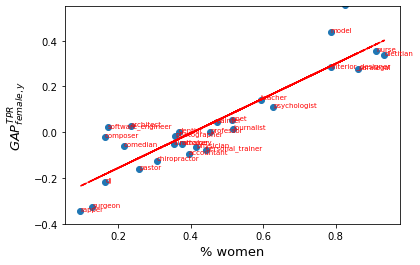

Correlation: 0.21163440987151053; p-value: 0.27964749939239536


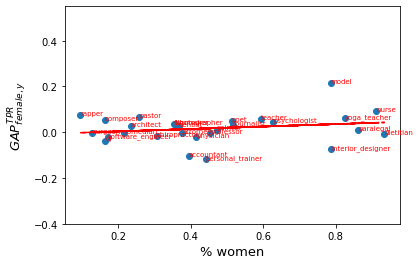

rms-diff before: 0.2138363635561522; rms-diff after: 0.06470837088492731


In [14]:
y_pred_before = clf_original.predict(x_test)
test_gender = [d["g"] for d in test]
tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred_before, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_before, None, "before", "TPR", prof2fem)


y_pred_after = clf.predict((P.dot(x_test.T)).T)
#y_pred_after = clf.predict(X_test)
tprs, tprs_change_after, mean_ratio_after = get_TPR(y_pred_after, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_after, None, "after", "TPR", prof2fem)

 
""" 
#print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))
 
fprs_before, fprs_change_before = get_FPR2(y_pred_before, y_dev, p2i, i2p, test_gender)
similarity_vs_tpr(fprs_change_before, None, "before", "FPR", prof2fem)


fprs, fprs_change_after = get_FPR2(y_pred_after, y_dev, p2i, i2p, test_gender)
similarity_vs_tpr(fprs_change_after, None, "after", "FPR", prof2fem)

#print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))
"""
change_vals_before = np.array(list((tprs_change_before.values())))
change_vals_after = np.array(list(tprs_change_after.values()))

print("rms-diff before: {}; rms-diff after: {}".format(rms_diff(change_vals_before), rms_diff(change_vals_after)))


### t-SNE by gender

In [14]:
def tsne_by_gender(vecs, labels, title, words = None):

  tsne = TSNE(n_components=2, random_state=0)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  names = list(set(labels)) # ["class {}".format(i) for i in range(num_labels)]
  plt.figure(figsize=(6, 5))
  colors = 'b', 'r', 'orange'
  markers = ["o", "s"]

  for i, c, label, marker in zip(set(labels.tolist()), colors, names, markers):
    print(len(vecs_2d[labels == i, 0]))
    plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label="Female" if label == 1 else "Male", alpha = 0.45, marker = marker)
  plt.legend(fontsize = 15, loc = "upper right")
  plt.title(title, fontsize = 15)
  
  if words is not None:
        k = 60
        for i in range(k):
            
            j = np.random.choice(range(len(words)))
            label = labels[i]
            w = words[j]
            x,y = vecs_2d[i]
            plt.annotate(w , (x,y), size = 10, color = "black" if label == 1 else "black")
  plt.savefig(title, dpi = 600)          
  plt.show()
  return vecs_2d

25
260


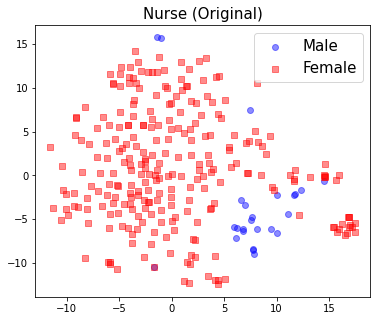

25
260


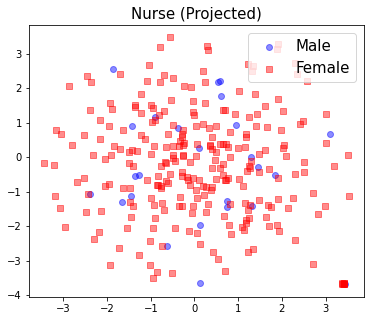

1077
923


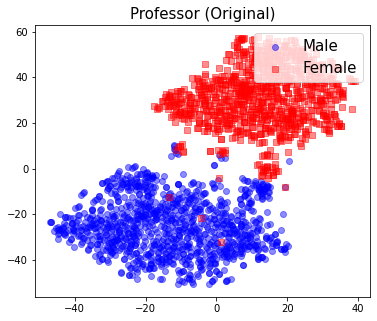

1077
923


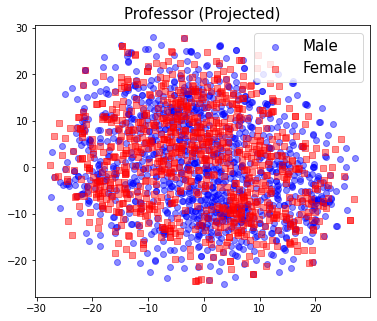

250
178


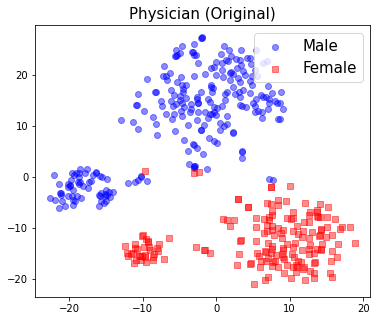

250
178


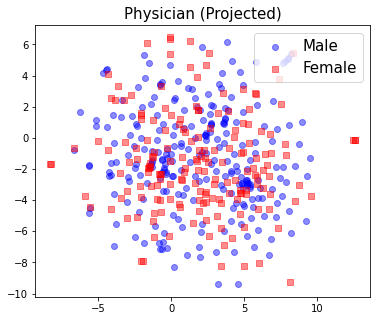

100
65


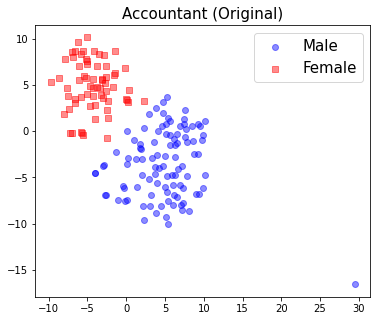

100
65


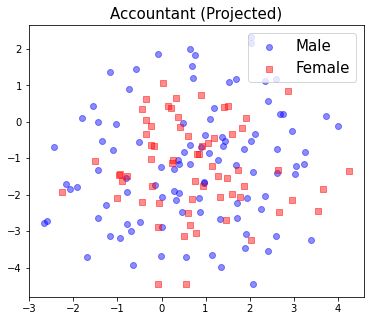

33
7


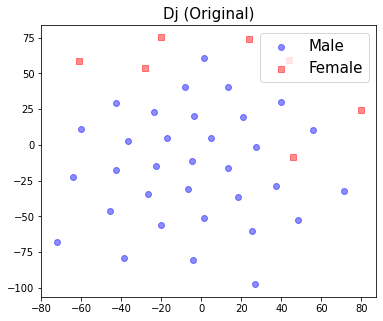

33
7


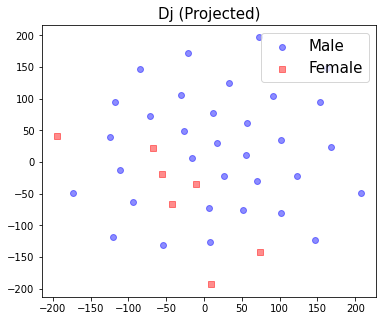

8
116


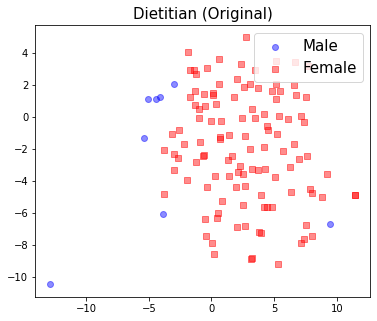

8
116


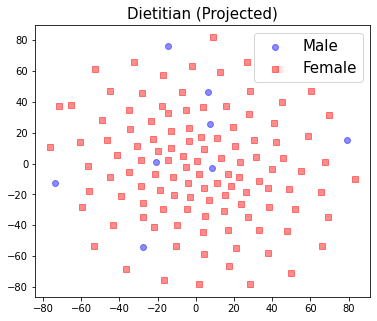

In [15]:
y_test_gender = np.array([d["g"] for d in dev])
n = 2000
for prof in ["nurse", "professor", "physician", "accountant", "dj", "dietitian"]:
    
    idx = np.random.rand(x_test.shape[0]) < 0.1
    prof_idx = y_dev == p2i[prof]  
    prof_upper = prof[0].upper() + prof[1:]
    tsne_by_gender(x_dev[prof_idx][:n], y_dev_gender[prof_idx][:n], "{} (Original)".format(prof_upper))
    tsne_by_gender((x_dev[prof_idx].dot(P))[:n], y_dev_gender[prof_idx][:n], "{} (Projected)".format(prof_upper))

1096
904


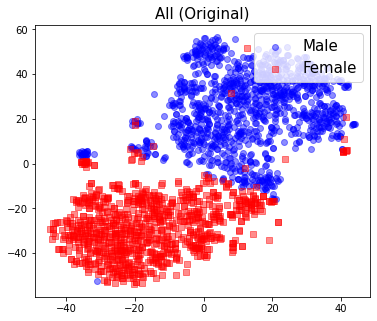

1096
904


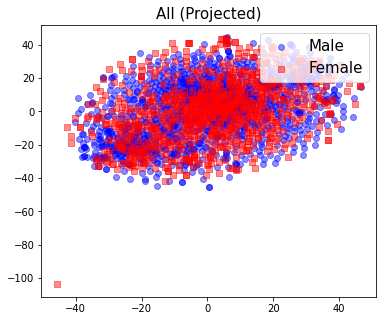

array([[-24.282417  , -17.13005   ],
       [  7.923804  ,   0.93445945],
       [-35.00177   ,   5.1822505 ],
       ...,
       [ 13.214887  ,   2.6645727 ],
       [-20.156536  ,  18.762133  ],
       [ -1.3964294 ,   7.082633  ]], dtype=float32)

In [16]:
tsne_by_gender(x_dev[:n], y_dev_gender[:n], "All (Original)".format(prof_upper))
tsne_by_gender((x_dev.dot(P))[:n], y_dev_gender[:n], "All (Projected)".format(prof_upper))

In [17]:
def visualize_gender_subspace(proj_matrices, vecs):
    
        labels = range(len(proj_matrices))
        N = len(labels)
        
        all_vecs = []
        all_labels = []
        
        for i,p in enumerate(proj_matrices):
            
            vecs_proj = vecs - vecs.dot(p)
            all_vecs.append(vecs_proj)
            all_labels.append(np.ones(vecs.shape[0]) * i)
        
        all_vecs_np = np.concatenate(all_vecs, axis = 0)
        all_labels_np = np.concatenate(all_labels, axis = 0)
        tsne = TSNE(n_components=2, random_state=0)
        vecs_2d = tsne.fit_transform(all_vecs_np)
    
        fig, ax = plt.subplots()
        # define the colormap
        cmap = plt.cm.jet
        # extract all colors from the .jet map
        cmaplist = [cmap(i) for i in range(cmap.N)]
        # create the new map
        cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
        # define the bins and normalize
        bounds = np.linspace(0, N, N + 1)
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
        print("here")
        print(all_labels_np.shape)
        scat = ax.scatter(vecs_2d[:,0], vecs_2d[:,1], c=all_labels_np, cmap=cmap, norm=norm, alpha=0.4)
        cb = plt.colorbar(scat, spacing='proportional')#, ticks=bounds)
        cb.set_label("INLP iteration number")
        plt.savefig("INLP progress", dpi = 600)
        plt.show()

In [18]:
visualize_gender_subspace(all_Ps[:25], x_dev[:5000])

NameError: name 'all_Ps' is not defined